In [1]:
import tensorflow as tf
import numpy as np
import tsp_env

In [2]:
hidden_size = 128
embedding_size = 128
max_time_steps = 10; input_size = 2;
batch_size = 128
initialization_stddev = 0.1

In [3]:
enc_inputs = tf.placeholder(tf.float32, [batch_size, max_time_steps, input_size])
W_embed = tf.Variable(tf.random_normal([embedding_size, input_size],
                                       stddev=initialization_stddev))
embedded_inputs = tf.einsum('kl,itl->itk', W_embed, enc_inputs)

In [4]:
with tf.variable_scope("encoder"):
    enc_rnn_cell = tf.nn.rnn_cell.LSTMCell(hidden_size)
    enc_outputs, enc_final_state = tf.nn.dynamic_rnn(cell=enc_rnn_cell, 
                                                     inputs=embedded_inputs,
                                                     dtype=tf.float32)

In [5]:
def attention_mask(W_ref, W_q, v, enc_outputs, query, already_played_actions=None, 
                   already_played_penalty=1e6):
    with tf.variable_scope("attention_mask"):
        u_i0s = tf.einsum('kl,itl->itk', W_ref, enc_outputs)
        u_i1s = tf.expand_dims(tf.einsum('kl,il->ik', W_q, query), 1)
        u_is = tf.einsum('k,itk->it', v, tf.tanh(u_i0s + u_i1s)) - already_played_penalty * already_played_actions
        return u_is, tf.nn.softmax(u_is)

In [6]:
with tf.variable_scope("decoder"):
    decoder_cell = tf.nn.rnn_cell.LSTMCell(hidden_size)
    decoder_state = [enc_final_state]
    first_decoder_input = tf.tile(tf.Variable(tf.random_normal([1, embedding_size]), 
                                      name='first_decoder_input'), [batch_size, 1])
    
    decoder_targets = tf.placeholder(dtype=tf.int32, shape=[batch_size, max_time_steps])
    
    with tf.variable_scope("attention_weights", reuse=True):
        W_ref = tf.Variable(tf.random_normal([embedding_size, embedding_size],
                                             stddev=initialization_stddev),
                           name='W_ref')
        W_q = tf.Variable(tf.random_normal([embedding_size, embedding_size],
                                           stddev=initialization_stddev),
                         name='W_q')
        v = tf.Variable(tf.random_normal([embedding_size], stddev=initialization_stddev),
                        name='v')
    
    # Training chain
    loss = 0
    decoder_input = first_decoder_input
    decoder_state = enc_final_state
    already_played_actions = tf.zeros(shape=[batch_size, max_time_steps], dtype=tf.float32)
    decoder_inputs = [decoder_input]
    for t in range(max_time_steps):
        dec_cell_output, decoder_state = decoder_cell(inputs=decoder_input, 
                                          state=decoder_state)
        attn_logits, _ = attention_mask(W_ref, W_q, v, enc_outputs, dec_cell_output,
                                        already_played_actions=already_played_actions,
                                        already_played_penalty=1e6)
        loss += tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(decoder_targets[:, t],
                                                                          depth=max_time_steps),
                                                        logits=attn_logits))
        loss_summary_sy = tf.summary.scalar('training_loss', loss)

        # Teacher forcing of the next input
        decoder_input = tf.einsum('itk,it->ik', embedded_inputs,
                                  tf.one_hot(decoder_targets[:, t], depth=max_time_steps))
        decoder_inputs.append(decoder_input)
        already_played_actions += tf.one_hot(decoder_targets[:, t], depth=max_time_steps)
    
    # Inference chain
    decoder_input = first_decoder_input
    decoder_state = enc_final_state
    decoder_outputs = []
    already_played_actions = tf.zeros(shape=[batch_size, max_time_steps], dtype=tf.float32)
    for t in range(max_time_steps):
        dec_cell_output, decoder_state = decoder_cell(inputs=decoder_input,
                                                      state=decoder_state)
        _, attn_mask = attention_mask(W_ref, W_q, v, enc_outputs, dec_cell_output,
                                      already_played_actions=already_played_actions,
                                      already_played_penalty=1e6)
        decoder_outputs.append(tf.argmax(attn_mask, axis=1))
        decoder_input = tf.einsum('itk,it->ik', embedded_inputs, attn_mask)
        already_played_actions += tf.one_hot(decoder_outputs[-1], depth=max_time_steps)

In [8]:
optimizer = tf.train.AdamOptimizer(1e-2)
train_op = optimizer.minimize(loss)

In [9]:
# Generate a batch of data
def generate_batch(n_cities, batch_size):
    inputs_list = []; labels_list = []
    env = tsp_env.TSP_env(n_cities, use_alternative_state=True)
    for i in range(batch_size):
        env.reset()
        s = env.reset()
        coords = s.reshape([4, n_cities])[:2, ].T
        inputs_list.append(coords)
        labels_list.append(env.optimal_solution()[1])
    return np.array(inputs_list), np.array(labels_list)

In [10]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
log_files_name = 'PointerNet-TSP5'
writer = tf.summary.FileWriter('/tmp/' + log_files_name, sess.graph)

1932.71
1.84706581207
1164.02
1.43337082941
843.223
1.23827504926
516.45
1.08655902801
539.293
1.05318710247
442.764
1.07505060358
441.321
1.05859506978
429.605
1.09639691263
414.12
1.06063726765
407.63
1.06324440677
406.542
1.0674630074
394.631
1.06518062815
433.739
1.05594344493
403.762
1.05361630671
368.75
1.06584705366
449.005
1.05865283626
370.119
1.05501567571
394.252
1.0631991011
363.634
1.04804667828
424.288
1.05605431789


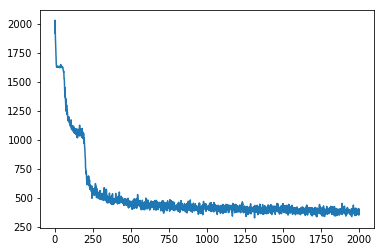

In [11]:
n_cities = 10

loss_vals = []
mean_approx_ratios = []
for i in range(2000):
    inputs_batch, labels_batch = generate_batch(n_cities, batch_size)
    loss_summary, loss_val, _ = sess.run([loss_summary_sy, loss, train_op], feed_dict={enc_inputs: inputs_batch, 
                                                        decoder_targets: labels_batch})
    loss_vals.append(loss_val)
    
    # Add training loss to tensorboard logs
    if i % 100 == 0:
        writer.add_summary(loss_summary, i)
        writer.flush()
        print(loss_vals[-1])
        
    # Test accuracy
    if i % 100 == 0:
        envs = []
        inputs_list = []
        optimal_rewards = []
        optimal_tours = []
        # Generate and initialize a batch of environments
        for i in range(batch_size):
            envs.append(tsp_env.TSP_env(n_cities, use_alternative_state=True))
            envs[-1].reset()
            inputs_list.append(envs[-1].nodes)
            optimal_solution = envs[-1].optimal_solution()
            optimal_rewards.append(optimal_solution[0])
            optimal_tours.append(optimal_solution[1])
        inputs_batch = np.array(inputs_list)
        # Use the PointerNet on this test batch and get its predictions
        predicted_outputs = np.array(sess.run(decoder_outputs, 
                                              feed_dict={enc_inputs: inputs_batch})).T
        # Compute the rewards corresponding to the predicted tours
        rewards = []
        for i in range(batch_size):
            for action in predicted_outputs[i]:
                envs[i].step(action)
            rewards.append(envs[i].accumulated_reward())
        # Get the approximation ratio of the predictions
        approximation_ratios = np.array(rewards) / np.array(optimal_rewards)
        mean_approx_ratios.append(np.mean(approximation_ratios))
        print(mean_approx_ratios[-1])

# Plot the training losses
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(loss_vals)